In [1]:
import numpy, pandas, xarray, matplotlib, rasterio, geopandas, cartopy, h5py, sklearn
print("All libraries imported successfully")



All libraries imported successfully


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

rgi = gpd.read_file("19_rgi50_AntarcticSubantarctic.shp")



In [4]:
print(rgi.columns)


Index(['RGIId', 'GLIMSId', 'RGIFlag', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'GlacType', 'Name', 'geometry'],
      dtype='object')


In [6]:
#Look for Pine islands now

subset = rgi[
    (rgi['CenLon'] > -110) & (rgi['CenLon'] < -90) &
    (rgi['CenLat'] > -78) & (rgi['CenLat'] < -72)
]

print(subset[['RGIId', 'Name', 'Area', 'CenLon', 'CenLat']])


               RGIId                                              Name  \
418   RGI50-19.00419  Thurston I 012                                 c   
419   RGI50-19.00420  Thurston I 003                                 c   
420   RGI50-19.00421  Thurston I 010                                 c   
422   RGI50-19.00423  Thurston I 001                                 c   
423   RGI50-19.00424  Thurston I 009                                 c   
...              ...                                               ...   
1400  RGI50-19.01401                                                 c   
1401  RGI50-19.01402                                                 c   
1402  RGI50-19.01403                                                 c   
1403  RGI50-19.01404                                                 c   
1404  RGI50-19.01405  Burke Island IC                                c   

          Area    CenLon   CenLat  
418    343.571  -95.9766 -72.1787  
419    329.495 -100.2680 -72.0723  
420

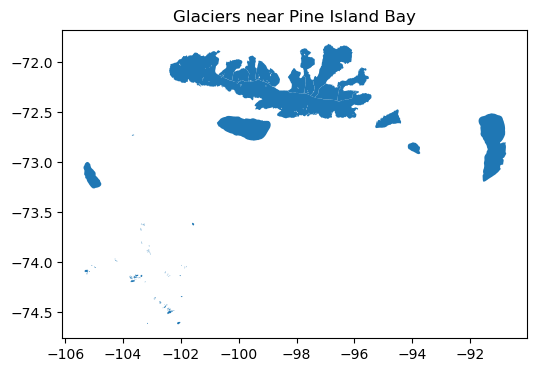

In [7]:
subset.plot(figsize=(6,6))
plt.title("Glaciers near Pine Island Bay")
plt.show()


Pine Island Glacier itself is not explicitly named in this RGI subset — which is common for large Antarctic outlet glaciers. Instead, it is represented as one or several large unnamed polygons near:
1. Lon ≈ −100
2. Lat ≈ −75
3. Area ≫ surrounding polygons
So we identify Pine Island Glacier by size and location, not by name.

Identify Pine Island Glacier polygon
Pine Island Glacier is very large (tens of thousands of km² upstream, several thousand km² in RGI depending on how truncated). So let’s sort by area.

In [8]:
subset.sort_values("Area", ascending=False).head(10)[
    ["RGIId", "Name", "Area", "CenLon", "CenLat"]
]


,RGIId,Name,Area,CenLon,CenLat
422,RGI50-19.00423,Thurston I 001 c,5260.723,-99.1619,-72.2868
1293,RGI50-19.01294,Fletcher Island IC c,1606.626,-91.2126,-72.8181
420,RGI50-19.00421,Thurston I 010 c,1211.753,-96.8004,-72.0311
767,RGI50-19.00768,Carpenter Island IC c,1135.086,-99.7792,-72.6540
423,RGI50-19.00424,Thurston I 009 c,515.825,-97.4996,-72.2515
425,RGI50-19.00426,Thurston I 006 c,470.984,-99.0264,-72.1312
430,RGI50-19.00431,Thurston I 008 c,402.445,-97.9857,-72.2054
428,RGI50-19.00429,Thurston I 011 c,373.632,-96.8980,-72.3066
418,RGI50-19.00419,Thurston I 012 c,343.571,-95.9766,-72.1787
419,RGI50-19.00420,Thurston I 003 c,329.495,-100.2680,-72.0723


Your current subset does NOT contain Pine Island Glacier.
All the large objects you see are:
Thurston Island ice caps
Fletcher Island ice cap
Carpenter Island ice cap


Correct Pine Island Glacier location
Approximate center of Pine Island Glacier:
Longitude ≈ −101°
Latitude ≈ −75.2°
So let’s search here instead:

In [9]:
subset2 = rgi[
    (rgi['CenLon'] > -110) & (rgi['CenLon'] < -90) &
    (rgi['CenLat'] > -77) & (rgi['CenLat'] < -74)
]

print(len(subset2))
subset2.sort_values("Area", ascending=False)[
    ["RGIId", "Name", "Area", "CenLon", "CenLat"]
].head(15)


70


,RGIId,Name,Area,CenLon,CenLat
1308,RGI50-19.01309,c,10.261,-102.396,-74.4996
1401,RGI50-19.01402,c,7.482,-105.269,-74.0880
1366,RGI50-19.01367,c,7.271,-103.668,-74.1887
1299,RGI50-19.01300,c,6.217,-102.080,-74.6067
1364,RGI50-19.01365,c,4.839,-103.581,-74.1487
1363,RGI50-19.01364,c,4.217,-103.528,-74.1320
1354,RGI50-19.01355,c,3.276,-103.365,-74.1369
1322,RGI50-19.01323,c,3.049,-102.545,-74.4441
1375,RGI50-19.01376,c,2.590,-103.731,-74.1572
1312,RGI50-19.01313,c,2.027,-102.396,-74.4757


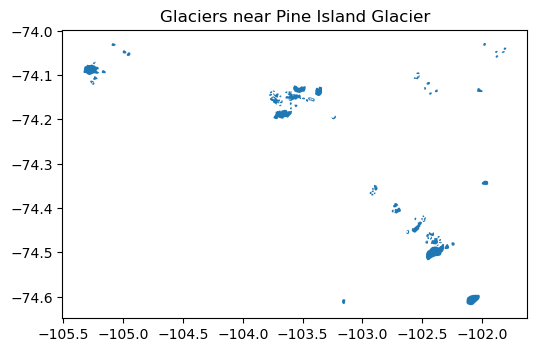

In [10]:
subset2.plot(figsize=(6,6))
plt.title("Glaciers near Pine Island Glacier")
plt.show()


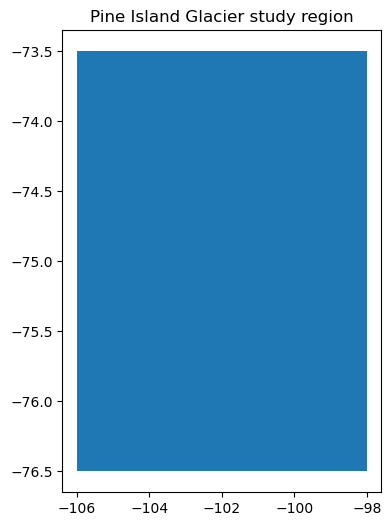

In [11]:
from shapely.geometry import box
import geopandas as gpd

pine_box = box(-106, -76.5, -98, -73.5)

pine_island = gpd.GeoDataFrame(
    {"Name": ["Pine Island Glacier"], "geometry": [pine_box]},
    crs="EPSG:4326"
)

pine_island.plot(figsize=(6,6))
plt.title("Pine Island Glacier study region")
plt.show()

pine_island.to_file("pine_island_region.shp")


                  Name                                           geometry
0  Pine Island Glacier  POLYGON ((-98 -76.5, -106 -76.5, -106 -73.5, -...


<Axes: >

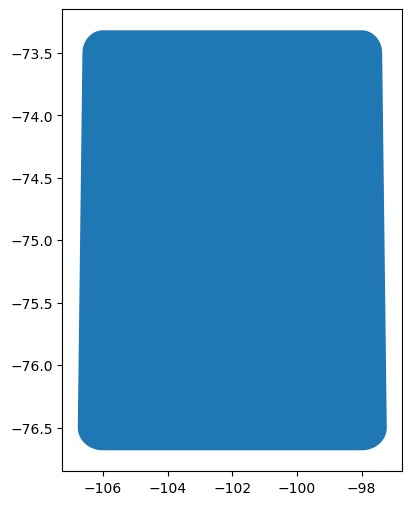

In [12]:
#Verify & buffer the Pine Island region

import geopandas as gpd

pine = gpd.read_file("pine_island_region.shp")
print(pine)

# Reproject to a polar stereographic projection for buffering
pine_ps = pine.to_crs("EPSG:3031")  # Antarctic polar stereographic

# Buffer by 20 km
pine_buf = pine_ps.buffer(20000)

# Convert back to lat/lon
pine_buf = gpd.GeoDataFrame(geometry=pine_buf, crs="EPSG:3031").to_crs("EPSG:4326")

pine_buf.plot(figsize=(6,6))
